# Start

In [ ]:
import os
import random
import time
import multiprocessing
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
from Bio.Seq import Seq
from Bio.Data.CodonTable import unambiguous_dna_by_id
from Bio.SeqUtils import seq3
from scipy.stats import spearmanr
from scipy.stats import pearsonr    
from tqdm.notebook import tqdm
from local_functions.functions import aa_dict_creator

CODONS = ['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 
          'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 
          'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 
          'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']
MUTATIONS = ['A_C', 'A_G', 'A_T', 'C_A', 'C_G', 'C_T', 'G_A', 'G_C', 'G_T', 'T_A', 'T_C', 'T_G']
CODON_TABLE = 2     # Вариации генетического кода с NCBI:
                    # 1: Standard   2: Vertebrate Mitochondrial 3: Yeast Mitochondrial
                    # 4: Mold Mitochondrial; Protozoan Mitochondrial; Coelenterate Mitochondrial; Mycoplasma; Spiroplasma
                    # 5: Invertebrate Mitochondrial     6: Ciliate Nuclear; Dasycladacean Nuclear; Hexamita Nuclear
                    # 9: Echinoderm Mitochondrial; Flatworm Mitochondrial   10: Euplotid Nuclear
                    # 11: Bacterial, Archaeal and Plant Plastid     12: Alternative Yeast Nuclear
                    # 13: Ascidian Mitochondrial    14: Alternative Flatworm Mitochondrial
                    # 16: Chlorophycean Mitochondrial   21: Trematode Mitochondrial
                    # 22: Scenedesmus obliquus Mitochondrial Code   23: Thraustochytrium mitochondrial code
                    # 24: Pterobranchia Mitochondrial   25: Candidate Division SR1; Gracilibacteria
                    # 26: Pachysolen tannophilus Nuclear Code   27: Karyorelict Nuclear     28: Condylostoma Nuclear
                    # 29: Mesodinium Nuclear    30: Peritrich Nuclear  31: Blastocrithidia Nuclear
MS = pd.read_csv(r'..\\raw\VertebratePolymorphisms.MutSpecData.OnlyFourFoldDegAllGenes.csv', sep=' ').copy()
MS = MS.set_index('Species')
MS = MS[MUTATIONS]
MS_2 = pd.read_csv(r"..\\raw\MutSpecVertebrates12.csv").copy()
MS_2 = MS_2.pivot(index=['Species', 'Gene'], columns='Mut', values='MutSpec')
MS_2 = MS_2.rename(index={'CO1': 'COX1', 'CO3': 'COX3', 'Cytb':'CytB'})
MS_2.columns = MS_2.columns.str.replace('>', '_')
MS_2 = MS_2[MUTATIONS]
CU = pd.read_csv(r'..\\raw\AllGenesCodonUsage.csv', sep='\t').copy()
CU = CU.drop_duplicates()
aa_dict_full = aa_dict_creator(True)
aa_dict = aa_dict_creator(True, full=False)

duplicated_species = CU[CU.duplicated(subset=['Species', 'Gene'])].Species
stop_codon_species = CU.groupby('Species')[aa_dict_full['Xaa']].first()[(CU.groupby('Species')[aa_dict_full['Xaa']].sum().sum(axis=1) > 0)].index
# excluding species without CU for all 13 protein-coding genes
full_cu_species = CU.groupby('Species').first().loc[(CU.groupby('Species').count().Gene == 13)].index
CU_13 = CU[(CU.Species.isin(full_cu_species)) 
           & (~CU.Species.isin(stop_codon_species))
           & (~CU.Species.isin(duplicated_species))]
CU_12 = CU_13.loc[CU_13.Gene != 'ND6'].groupby('Species')[CODONS].sum()
CU_ND6 = CU_13.loc[CU_13.Gene == 'ND6'].set_index('Species')[CODONS]
CU_12_FREQ = CU_12[CODONS].div(CU_12[CODONS].sum(axis=1), axis=0)
AAU_12 = pd.DataFrame(data={aa: CU_12[aa_dict_full[aa]].sum(axis=1) 
                      for aa in aa_dict_full})
# list of species with stop codons in their codon usage
err_list = ['Acheilognathus_macropterus', 'Acheilognathus_yamatsutae', 'Acipenser_gueldenstaedtii', 'Ara_militaris', 'Brotogeris_cyanoptera', 'Capra_sibirica', 'Cardinalis_cardinalis', 'Chlorocebus_aethiops', 'Chlorocebus_sabaeus', 'Cobitis_sinensis', 'Conolophus_subcristatus', 'Crocidura_russula', 'Crocodylus_moreletii', 'Dasyurus_hallucatus', 'Desmognathus_fuscus', 'Eulemur_rubriventer', 'Eurystomus_orientalis', 'Falco_sparverius', 'Fringilla_coelebs', 'Gyrinophilus_porphyriticus', 'Oncorhynchus_keta', 'Scombrops_gilberti']
simulation_species = os.listdir(r'C:\Work\Lab\Practice\Results_AllGenes_shift')
simulation_species = sorted(list(set(simulation_species)-set(err_list)))

mutations_number = 150*150       # ~22k достаточно для насыщения изменения кодонов
mutations_per_iter = 100
sim_iters_number = mutations_number // mutations_per_iter
# result_folder = '..\\local data\Simulation results(sel)'

# Change tRNA sequencies to dna ones
cognate_acs = {'Ala': 'UGC', 'Arg': 'UCG', 'Asn': 'GUU', 'Asp': 'GUC', 'Cys': 'GCA', 'Gln': 'UUG', 
               'Glu': 'UUC', 'Gly': 'UCC', 'His': 'GUG', 'Ile': 'GAU', 'Leu1': 'UAG', 'Leu2': 'UAA', 
               'Lys': 'UUU', 'Met': 'CAU', 'Phe': 'GAA', 'Pro': 'UGG', 'Ser1': 'GCU', 
               'Ser2': 'UGA', 'Thr': 'UGU', 'Trp': 'UCA', 'Tyr': 'GUA', 'Val': 'UAC'}
# Dictionary of codons pairing by WC rule
cognate_codons = {}
for aa, ac in cognate_acs.items():
        cognate_codons[aa] = str(Seq(ac).reverse_complement())
# Codon translation dictionary
codon_to_aa = {}
for aa in aa_dict_full:
    for codon in aa_dict_full[aa]:
        codon_to_aa[codon] = aa

In [3]:
simulation_species = CU_12[CU_12.index.isin(MS.index)].index.tolist()
len(simulation_species)

862

# No sel simulation

In [ ]:
result_folder = '..\\local data\Simulation results(no sel & new ms)'

for species in tqdm(simulation_species[:1]): # Цикл по списку видов
    probability = 0
    mutspec = MS[MS.index == species].iloc[0].tolist()  # Вытаскивает мутспек для текущего вида
    mutspec_stack = []

    for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
        mutspec_stack.append(probability)
        probability += float(mutspec[i])


    for sample in range(20): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{species}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе final_simulation_cu текущего вида
        dna = []

        for aa in AAU_12.columns.values[:-1]:
            odds = [0]
            for i in range(len(aa_dict_seq3[aa])):    # Создаем список вероятностей по вырождености аминокислоты
                odds.append(random.random() + odds[-1])
            for k in range(AAU_12[AAU_12.Species == species][aa].values[0]):  # Цикл длиной кол-ву кодонов для аминокислоты
                odd = random.uniform(0, odds[-1])
                for q in range(len(aa_dict_seq3[aa])):    # Для учета вырожденности АА
                    if odd < odds[q+1] and odd > odds[q]:
                        dna.append(aa_dict_seq3[aa][q])

        codon_usage_list = []     # Создаем датафреймы для подсчета final_simulation_cu и
        frequency_list = []
        observed_frequency = pd.read_csv(r'C:\Work\Lab\Practice\CodonFrequencyAllGenes.csv', sep='\t').copy()
        frequency_list.append(list(observed_frequency[observed_frequency.Species == species].values[0][1:]))    # Записывает частоты кодонов из живого генома текущего вида

        MUTATIONS = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']
            # Список однонуклеотидных замен
        codon_mut_choice_time = 0
        for generation in range(sim_iters_number):
            errouneous_sp_counter = 0
            if generation % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                sim_codon_usage = Counter(dna)      # Расчет final_simulation_cu
                codon_usage_list.append([])
                if len(list(sim_codon_usage)) < 64:                     # Проверка наличия всех 64 кодонов
                    for t in CODONS:                              # без нее возникали ошибки
                        if t not in list(sim_codon_usage):              # если кодон исчезает приписываем ему ноль
                            sim_codon_usage[t] = 0
                for codon in CODONS:     # Записывает final_simulation_cu
                    codon_usage_list[generation].append(sim_codon_usage[codon])
                frequency_values = []  # Список значений частот кодонов
                for e in range(64):
                    frequency_values.append(codon_usage_list[generation][e] / len(dna))   # Расчитывает частоту каждого кодона
                frequency_list.append(frequency_values)  # Записывает в строку текущего поколения

                # Сохраняет значения

            # Мутагенез через список кодонов
            successfull_mutations = 0
            
            while successfull_mutations < mutations_per_iter:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_mut_choice_timer = time.time()

                codon_id = random.randint(0, len(dna)-1)
                codon = MutableSeq(dna[codon_id])   # Выбираем отдельный кодон
                mutation_position = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                # mut_id = 2
                mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                counter = 0
                while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                    counter += 1

                if codon[mutation_position] == MUTATIONS[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                    new_codon = MutableSeq(codon)                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mutation_position] = MUTATIONS[counter][2]           # Подставляем нуклеотид в кодоне
                    codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    new_codon_aa = seq3(new_codon.translate(table=CODON_TABLE))
                    
                    if new_codon_aa != codon_aa:
                        continue
        
                    # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
                    # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
                    
                    success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                # it's impossible to make a substitution more frequent without it
                    selection_multiplier = 0
                    
                    if success < (0.8+0.8*selection_multiplier):
                        dna[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                        successfull_mutations += 1


        codon_usage_df = pd.DataFrame(data=codon_usage_list, columns=CODONS)
        frequency_df = pd.DataFrame(data=frequency_list, columns=CODONS)
        
        codon_usage_df.to_csv(fr'{result_folder}\{species}\{sample}\Codons.csv', sep='\t', index=False)
        frequency_df.to_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep ='\t', index=False)
        
        # Расчет корреляций и p-value
        data = pd.read_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        spearman = []
        pearson = []
        spearman_pval = []
        pearson_pval = []
        observed_cu = data.loc[0]
        for i in data.index.values[1:]:
            simulated_cu = data.loc[i]
            corrp, p_p = pearsonr(observed_cu, simulated_cu)
            corrs, p_s = spearmanr(observed_cu, simulated_cu)
            spearman.append(corrs)
            pearson.append(corrp)
            spearman_pval.append(p_s)
            pearson_pval.append(p_p)
        spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'spearman_pval':spearman_pval, 'pearson_pval':pearson_pval})
        spear_corr.to_csv(fr'{result_folder}\{species}\{sample}\Spearman.csv', sep='\t', index=False)    # Расчет корреляций закончен



        # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    samples_number = len(next(os.walk(fr'{result_folder}\{species}'))[1])    # Количество смодулированных образцов
    # for i in next(os.walk(fr'{result_folder}\{species}'))[1]:     
    #     # if i.isnumeric(): 
    #     samples_number += 1                   # os.walk выдает кортежи(path, dirnames, filenames)

    # Средние частоты
    frequencies_mean_df = pd.DataFrame(0, index=range(sim_iters_number+1), columns=CODONS)


    for sample in range(samples_number):
        freq = pd.read_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        frequencies_mean_df += freq
    frequencies_mean_df /= samples_number
    
    frequencies_mean_df.to_csv(fr'{result_folder}\{species}\FrequenciesMean.csv', sep='\t', index=False)

    # Корреляции
    spearman = []
    pearson = []
    spearman_pval = []
    pearson_pval = []
    observed_cu = frequencies_mean_df.loc[0]
    for i in frequencies_mean_df.index[1:]:
        simulated_cu = frequencies_mean_df.loc[i]
        corrp, p_p = pearsonr(observed_cu, simulated_cu)
        pearson.append(corrp)
        pearson_pval.append(p_p)
        corrs, p_s = spearmanr(observed_cu, simulated_cu)
        spearman.append(corrs)
        spearman_pval.append(p_s)
    
    spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'spearman_pval':spearman_pval, 'pearson_pval':pearson_pval})
    spear_corr.to_csv(fr'{result_folder}\{species}\SpearmanMean.csv', sep='\t', index=False)

print(errouneous_sp_list)

# Selection simulation

In [ ]:
errouneous_sp_list = set()

# simulation_species = os.listdir('C:\Work\Lab\Practice\Results_AllGenes_shift')
# simulation_species = sorted(list(set(simulation_species)-set(err_list)))
result_folder = '..\\local data\Simulation results(sel)'

for species in tqdm(simulation_species[:1]): # Цикл по списку видов
    probability = 0
    mutspec = MS[MS.index == species].iloc[0].tolist()  # Вытаскивает мутспек для текущего вида
    mutspec_stack = []

    for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
        mutspec_stack.append(probability)
        probability += float(mutspec[i])


    for sample in range(20): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{species}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе final_simulation_cu текущего вида
        dna = []

        for aa in AAU_12.columns.values[:-1]:
            odds = [0]
            for i in range(len(aa_dict_seq3[aa])):    # Создаем список вероятностей по вырождености аминокислоты
                odds.append(random.random() + odds[-1])
            for k in range(AAU_12[AAU_12.Species == species][aa].values[0]):  # Цикл длиной кол-ву кодонов для аминокислоты
                odd = random.uniform(0, odds[-1])
                for q in range(len(aa_dict_seq3[aa])):    # Для учета вырожденности АА
                    if odd < odds[q+1] and odd > odds[q]:
                        dna.append(aa_dict_seq3[aa][q])

        codon_usage_list = []     # Создаем датафреймы для подсчета final_simulation_cu и
        frequency_list = []
        CU_12_FREQ = pd.read_csv(r'C:\Work\Lab\Practice\CodonFrequencyAllGenes.csv', sep='\t').copy()
        observed_frequency = list(CU_12_FREQ[CU_12_FREQ.Species == species].values[0][1:])
        frequency_list.append(observed_frequency)
            # Записывает частоты кодонов из живого генома текущего вида

        MUTATIONS = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']
            # Список однонуклеотидных замен

        for generation in range(sim_iters_number):
            errouneous_sp_counter = 0
            if generation % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                sim_codon_usage = Counter(dna)      # Расчет final_simulation_cu
                codon_usage_list.append([])
                if len(list(sim_codon_usage)) < 64:                     # Проверка наличия всех 64 кодонов
                    for t in CODONS:                              # без нее возникали ошибки
                        if t not in list(sim_codon_usage):              # если кодон исчезает приписываем ему ноль
                            sim_codon_usage[t] = 0
                for codon in CODONS:     # Записывает final_simulation_cu
                    codon_usage_list[generation].append(sim_codon_usage[codon])
                frequency_values = []  # Список значений частот кодонов
                for e in range(64):
                    frequency_values.append(codon_usage_list[generation][e] / len(dna))   # Расчитывает частоту каждого кодона
                frequency_list.append(frequency_values)  # Записывает в строку текущего поколения
                # Сохраняет значения

            # Мутагенез через список кодонов
            successfull_mutations = 0

            while successfull_mutations < mutations_per_iter:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_id = random.randint(0, len(dna)-1)
                codon = MutableSeq(dna[codon_id])   # Выбираем отдельный кодон
                mutation_position = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                counter = 0
                while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                    counter += 1
                if codon[mutation_position] == MUTATIONS[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                    
                    new_codon = codon                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mutation_position] = MUTATIONS[counter][2]           # Подставляем нуклеотид в кодоне
                    codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
                    
                    if codon_aa=='Ter':
                        errouneous_sp_list.add(species)
                        break

                    if new_codon_aa != codon_aa:
                        continue
        
                    codon_cognation = True if codon == ac_codon_dict[codon_aa] else False
                    new_codon_cognation = True if new_codon == ac_codon_dict[new_codon_aa] else False
                    
                    success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                # it's impossible to make a substitution more frequent without it
                    
                    if codon_cognation == new_codon_cognation and new_codon_cognation == True:
                        selection_multiplier = 0.1
                    elif codon_cognation == new_codon_cognation and new_codon_cognation == False:
                        selection_multiplier = -0.1
                    else:
                        selection_multiplier = 0
                    if success < (0.8+0.8*selection_multiplier):
                        dna[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                        successfull_mutations += 1
                    

        #         errouneous_sp_counter += 1
        #         if errouneous_sp_counter > 15000:
        #             errouneous_sp_list.append(species)
        #             print('{} is a errouneous_sp'.format(species))
        #             breaker = True
        #             break
        #     if breaker == True:
        #         break
        # if breaker == True:
        #     break
        
        codon_usage_df = pd.DataFrame(data=codon_usage_list, columns=CODONS)
        frequency_df = pd.DataFrame(data=frequency_list, columns=CODONS)
        
        codon_usage_df.to_csv(fr'{result_folder}\{species}\{sample}\Codons.csv', sep='\t', index=False)
        frequency_df.to_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep ='\t', index=False)

        # Расчет корреляций и p-value
        # data = pd.read_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        # spearman = []
        # pearson = []
        # spearman_pval = []
        # pearson_pval = []
        # for i in data.index.values[1:]:
        #     data1, data2 = data.loc[0], data.loc[i]
        #     corrp, p_p = pearsonr(data1, data2)
        #     corrs, p_s = spearmanr(data1, data2)
        #     spearman.append(corrs)
        #     pearson.append(corrp)
        #     spearman_pval.append(p_s)
        #     pearson_pval.append(p_p)
        # spear_corr = pd.DataFrame(index=[i for i in range(TOTAL_GENERATIONS)], columns=['spearman', 'spearman_pval', 'pearson', 'pearson_pval'])
        # spear_corr['spearman'] = spearman
        # spear_corr['pearson'] = pearson
        # spear_corr['spearman_pval'] = spearman_pval
        # spear_corr['pearson_pval'] = pearson_pval
        # spear_corr.to_csv(fr'{result_folder}\{species}\{sample}\Spearman.csv', sep='\t', index=False)    # Расчет корреляций закончен



    # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    samples_number = len(next(os.walk(fr'{result_folder}\{species}'))[1])    # Количество смодулированных образцов
    # for i in next(os.walk(fr'{result_folder}\{species}'))[1]:     
    #     # if i.isnumeric(): 
    #     samples_number += 1                   # os.walk выдает кортежи(path, dirnames, filenames)

    # Средние частоты
    frequencies_mean_df = pd.DataFrame(0, index=range(sim_iters_number+1), columns=CODONS)


    for sample in range(samples_number):
        freq = pd.read_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        frequencies_mean_df += freq
    frequencies_mean_df /= samples_number
    
    frequencies_mean_df.to_csv(fr'{result_folder}\{species}\FrequenciesMean.csv', sep='\t', index=False)

    # Корреляции
    spearman = []
    pearson = []
    spearman_pval = []
    pearson_pval = []
    observed_cu = frequencies_mean_df.loc[0]
    for i in frequencies_mean_df.index[1:]:
        simulated_cu = frequencies_mean_df.loc[i]
        corrp, p_p = pearsonr(observed_cu, simulated_cu)
        pearson.append(corrp)
        pearson_pval.append(p_p)
        corrs, p_s = spearmanr(observed_cu, simulated_cu)
        spearman.append(corrs)
        spearman_pval.append(p_s)
    
    spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'spearman_pval':spearman_pval, 'pearson_pval':pearson_pval})
    spear_corr.to_csv(fr'{result_folder}\{species}\SpearmanMean.csv', sep='\t', index=False)

print(errouneous_sp_list)

  0%|          | 0/1 [00:00<?, ?it/s]

set()


# Functions

## dna generator

In [3]:
def constrained_sum_sample_nonneg(n: int, total: int) -> list[int]:
    """
    Return a randomly chosen list of `n` nonnegative integers summing up to `total`.
    Each such list is equally likely to occur.
    """

    dividers = sorted(random.sample(range(1, total + n), n - 1))
    non_zero = [a - b for a, b in zip(dividers + [total + n], [0] + dividers)]
    return [x - 1 for x in non_zero]

In [4]:
def dna_generator_str(aa_dict, codon_usage):
    dna = []
    aau = {aa: codon_usage[aa_dict_full[aa]].sum() for aa in aa_dict_full}
    for aa in aa_dict:
        probs = np.random.uniform(0, 1, len(aa_dict[aa]))
        aa_codon_number = aau[aa]
        dna += random.choices(population=aa_dict[aa], weights=probs, k=aa_codon_number)
    return dna

In [5]:
def dna_generator_dict(aa_dict, codon_usage: pd.Series):
    dna = {}
    aau = {aa: codon_usage[aa_dict_full[aa]].sum() for aa in aa_dict_full}
    for aa in aa_dict:
        if aa != 'Xaa':
            aa_codon_number = aau[aa]
            values = constrained_sum_sample_nonneg(len(aa_dict[aa]), aa_codon_number)
            for idx, codon in enumerate(aa_dict[aa]):
                dna[codon] = values[idx]
        else:
            for codon in aa_dict[aa]:
                dna[codon] = 0
    return dict(sorted(dna.items()))

In [6]:
# check if local variables in dna_record rewrite global ones\
aa = []
bb = 0
def a_filler(a, b):
    a.append('1')
    b = b + 1
a_filler(aa, bb)
print(aa, bb)

['1'] 0


## Mutagenesis

In [7]:
simulation_cu = [codon_usage.tolist()]
record_frequency = 100
iteration_number = 22500

NameError: name 'codon_usage' is not defined

In [8]:
def mutagenesis_str(dna: list[str], mutspec, iteration_number, 
                    codon_to_aa, simulation_cu, record_frequency, selection_multiplier: float = None): # for dict
    successfull_mutations = 0
    while successfull_mutations <= iteration_number:
        codon_id = random.randint(0, len(dna) - 1)
        codon = dna[codon_id]   # Выбираем отдельный кодон
        mutation_position = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
        # mutation_position = 2  # Probably it doesn't make sense to select non 3rd nucleotides in a codon
        mutation_type = random.choices(population=MUTATIONS, weights=mutspec, k=1)[0]
        if codon[mutation_position] == mutation_type[0]:              # Сопоставляем нуклеотид замены из мутспека с
            new_codon = codon[:mutation_position] + mutation_type[2] + codon[mutation_position + 1:]
            codon_aa = codon_to_aa[codon]
            new_codon_aa = codon_to_aa[new_codon]
            codon_aa = codon_to_aa[codon]
            new_codon_aa = codon_to_aa[new_codon]
            
            if new_codon_aa != codon_aa:
                continue
            
            if selection_multiplier == None:
                dna[codon_id] = new_codon
                successfull_mutations += 1
                if successfull_mutations % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                    codon_usage_rand = Counter(dna) | {stop_codon:0 for stop_codon in aa_dict_full['Xaa']}  # Расчет final_simulation_cu
                    iteration_cu = [codon_usage_rand[codon] if codon in codon_usage_rand else 0 for codon in CODONS]
                    simulation_cu.append(iteration_cu)
            else:
                selection_enhancer(dna, codon, new_codon)

In [9]:
def mutagenesis_np(dna: list[str], mutspec, iteration_number, 
                    codon_to_aa, simulation_cu, record_frequency, 
                    selection_multiplier: float = None, np_multiplier: int = 75):
    codon_ids = np.random.randint(0, len(dna), size=iteration_number*np_multiplier)
    mutation_positions = np.random.randint(0, 3, size=iteration_number*np_multiplier)
    mutation_types = np.random.choice(MUTATIONS, size=iteration_number*np_multiplier, p=mutspec)        
    # mutation_position = 2  # Probably it doesn't make sense to select non 3rd nucleotides in a codon
    successfull_mutations = 0
    idx = 1
    while successfull_mutations <= iteration_number:
        codon_id = codon_ids[idx]
        mutation_position = mutation_positions[idx]
        mutation_type = mutation_types[idx]

        codon = dna[codon_id]
        if codon[mutation_position] == mutation_type[0]:
            new_codon = codon[:mutation_position] + mutation_type[2] + codon[mutation_position + 1:]
            if codon_to_aa.get(new_codon) == codon_to_aa.get(codon):
                dna[codon_id] = new_codon
                successfull_mutations += 1
                if successfull_mutations % record_frequency == 0:
                    codon_usage_rand = Counter(dna)
                    iteration_cu = [codon_usage_rand.get(codon, 0) for codon in CODONS]
                    simulation_cu.append(iteration_cu)
        idx += 1
            # if selection_multiplier == None:
            #     dna[codon_id] = new_codon
            #     successfull_mutations += 1
            #     if successfull_mutations % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
            #         codon_usage_rand = Counter(dna) | {stop_codon:0 for stop_codon in aa_dict_full['Xaa']}  # Расчет final_simulation_cu
            #         iteration_cu = [codon_usage_rand[codon] if codon in codon_usage_rand else 0 for codon in CODONS]
            #         simulation_cu.append(iteration_cu)
            # else:
            #     selection_enhancer(dna, codon, new_codon)

In [10]:
def dna_dict_update(dna_dict: dict[str, int], codon: str, new_codon: str) -> None:
    dna_dict[codon] -= 1
    dna_dict[new_codon] += 1

def selection_enhancer(dna, codon, new_codon, selection_multiplier):
    '''
    simulation_dict only
    '''
    codon_cognation = True if codon == cognate_codons[codon_aa] else False
    new_codon_cognation = True if new_codon == cognate_codons[new_codon_aa] else False
    
    # 'mutation_threshold' treshold is needed for possibility of positive selection 
    # it's impossible to make a substitution more frequent without it
    success = random.random()
    if codon_cognation != new_codon_cognation and new_codon_cognation == True:
        dna_dict_update(dna, codon, new_codon)
        successfull_mutations += 1
    elif codon_cognation != new_codon_cognation and new_codon_cognation == False:
        if success < (1 - selection_multiplier*2):
            dna_dict_update(dna, codon, new_codon)
            successfull_mutations += 1
    else:
        if success < (1 - selection_multiplier):
            dna_dict_update(dna, codon, new_codon)
            successfull_mutations += 1

def mutagenesis(dna: dict[str, int], mutspec: pd.Series, iteration_number: int, codon_to_aa: dict, 
                simulation_cu: list[list[dict]], record_frequency: int, selection_multiplier: float): # for dict
    '''
    
    '''
    successfull_mutations: int = 0
    while successfull_mutations <= iteration_number:
        codon = random.choices(CODONS, dna.values(), k=1)[0]
        mutation_position = random.randint(0, 2)
        # mutation_position = 2  # Probably it doesn't make sense to select non 3rd nucleotides in a codon
        mutation_type = random.choices(population=MUTATIONS, weights=mutspec, k=1)[0]
        if codon[mutation_position] == mutation_type[0]:              # Сопоставляем нуклеотид замены из мутспека с
            new_codon = codon[:mutation_position] + mutation_type[2] + codon[mutation_position+1 :]
            codon_aa = codon_to_aa[codon]
            new_codon_aa = codon_to_aa[new_codon]
            
            if new_codon_aa != codon_aa:
                continue
            
            if selection_multiplier == None:
                dna_dict_update(dna, codon, new_codon)
                successfull_mutations += 1
                if successfull_mutations % record_frequency == 0: 
                    iteration_cu = list(dna.values())
                    simulation_cu.append(iteration_cu)                
            else:
                selection_enhancer(dna, codon, new_codon, selection_multiplier)

## Samples mean

In [11]:
def mean_cu_records_calculation(result_folder: str) -> pd.DataFrame:
    total_samples_number = len(next(os.walk(fr'{result_folder}'))[1])    # Количество смодулированных образцов
    mean_simulation_cu_records = pd.read_csv(fr'{result_folder}\0\Codons.csv', sep='\t').copy()
    for sample in range(1, total_samples_number):
        simulation_cu = pd.read_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
        mean_simulation_cu_records += simulation_cu
    mean_simulation_cu_records /= total_samples_number
    return mean_simulation_cu_records

## Simulation

In [11]:
def simulation_old(species: str, result_folder: str, codon_usage: pd.Series, 
               mutspec, selection_multiplier: bool = None, samples_number: int = 20,
               continuation = False):
    # mutspec = MS[MS.index == species].iloc[0].tolist()  # Вытаскивает мутспек для текущего вида
    mutspec_stack = []
    probability = 0
    for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
        mutspec_stack.append(probability)
        probability += float(mutspec[i])
    
    codons_sum = codon_usage.sum()
    observed_frequency = (codon_usage / codons_sum).tolist()

    for sample in range(samples_number): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе final_simulation_cu текущего вида
        if continuation == False:
            dna = dna_generator(species, codon_usage_species=codon_usage)
        else:
            existed_DNA_df = pd.read_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
            existed_codons = existed_DNA_df.iloc[-1]
            dna = []
            for codon in existed_codons.index:
                dna += [codon]*existed_codons[codon]

        simulation_cu = [codon_usage.tolist()]     # Создаем датафреймы для подсчета final_simulation_cu и
        simulation_frequencies = []
        simulation_frequencies.append(observed_frequency)
            # Записывает частоты кодонов из живого генома текущего вида

        for generation in range(sim_iters_number):
            if generation % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                codon_usage_rand = Counter(dna) | {stop_codon:0 for stop_codon in aa_dict_full['Xaa']}  # Расчет final_simulation_cu
                simulation_cu.append([])
                for codon in CODONS:     # Записывает final_simulation_cu
                    if len(codon_usage_rand) < 64:  # Проверка наличия всех 64 кодонов, без нее возникали ошибки
                        if codon not in list(codon_usage_rand):              # если кодон исчезает приписываем ему ноль
                            codon_usage_rand[codon] = 0
                    simulation_cu[generation].append(codon_usage_rand[codon])  # Список значений частот кодонов
                frequency_values = list(np.array(simulation_cu[generation]) / len(dna)) # Расчитывает частоту каждого кодона
                simulation_frequencies.append(frequency_values)  # Записывает в строку текущего поколения
                

            # Мутагенез через список кодонов
            mut_counter = 0
            
            while mut_counter < int(mutations_per_iter*(codons_sum/codons_sum_all_genes)):        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_id = random.randint(0, len(dna)-1)
                codon = MutableSeq(dna[codon_id])   # Выбираем отдельный кодон
                mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                counter = 0
                while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                    counter += 1
                if codon[mut_id] == MUTATIONS[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                    new_codon = codon                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mut_id] = MUTATIONS[counter][2]           # Подставляем нуклеотид в кодоне

                    # codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    # new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
                    codon_aa = codon_to_aa[str(codon)]
                    new_codon_aa = codon_to_aa[str(new_codon)]
                    
                    if new_codon_aa != codon_aa:
                        continue
                    
                    if selection_multiplier != None:
                        codon_WCF = True if codon == cognate_codons[codon_aa] else False
                        new_codon_WCF = True if new_codon == cognate_codons[new_codon_aa] else False
                        success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                    # it's impossible to make a substitution more frequent without it
                        
                        if codon_WCF != new_codon_WCF and new_codon_WCF == True:
                            dna[codon_id] = new_codon    # Проверка на синонимичность мутировавшего кодона
                            mut_counter += 1
                        elif codon_WCF != new_codon_WCF and new_codon_WCF == False:
                            if success < (1 - selection_multiplier*2):
                                dna[codon_id] = new_codon    # Проверка на синонимичность мутировавшего кодона
                                mut_counter += 1
                        else:
                            if success < (1-selection_multiplier):
                                dna[codon_id] = new_codon    # Проверка на синонимичность мутировавшего кодона
                                mut_counter += 1
                    else:
                        dna[codon_id] = new_codon     # Проверка на синонимичность мутировавшего кодона
                        mut_counter += 1
        if continuation == False:
            final_simulation_cu = pd.DataFrame(data=simulation_cu, columns=CODONS)
            final_frequencies = pd.DataFrame(data=simulation_frequencies, columns=CODONS)
        else:
            existed_final_simulation_cu = pd.read_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
            existed_final_frequencies = pd.read_csv(fr'{result_folder}\{sample}\Frequencies.csv', sep ='\t').copy()
            final_simulation_cu = pd.concat([existed_final_simulation_cu, final_simulation_cu], ignore_index=True)
            final_frequencies = pd.concat([existed_final_frequencies, final_frequencies], ignore_index=True)

        correlation_calculation(data=final_frequencies, result_folder=result_folder, species=species, sample=sample)
        final_simulation_cu.to_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t', index=False)
        final_frequencies.to_csv(fr'{result_folder}\{sample}\Frequencies.csv', sep ='\t', index=False)
        

    # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    existed_samples_number = len(next(os.walk(fr'{result_folder}'))[1])    # Количество смодулированных образцов

    mean_final_frequencies = pd.DataFrame(0, index=range(sim_iters_number+1), columns=CODONS)

    for sample in range(existed_samples_number):
        freq = pd.read_csv(fr'{result_folder}\{sample}\Frequencies.csv', sep='\t').copy()
        mean_final_frequencies += freq
    mean_final_frequencies /= existed_samples_number

    mean_final_frequencies.to_csv(fr'{result_folder}\FrequenciesMean.csv', sep='\t', index=False)
    correlation_calculation(mean_final_frequencies, result_folder, species)

In [12]:
def simulation(result_folder: str, codon_usage: pd.Series, mutspec: pd.Series, 
               iteration_number: int = 22500, record_frequency: int = 100, selection_multiplier: bool = None, 
               samples_number: int = 20, simulation_continuation: bool = False):
    '''
    Simulate evolution a codon usage of a species according to its mutational spectrum
    Parameters:
    result_folder: a working directory. The directory leaf must be species-specific 
    codon_usage: Species- and gene-specific codon usage. The second is optional
    mutspec: Species- and gene-specific mutational spectrum. The second is optional
    '''
    for sample in tqdm(range(samples_number)):
        os.makedirs(fr"{result_folder}/{sample}", exist_ok=True)

        if simulation_continuation == False:
            dna = dna_generator_dict(aa_dict=aa_dict_full, codon_usage=codon_usage)
        else:
            existed_cu_records = pd.read_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
            last_record = existed_cu_records.iloc[-1]
            dna = last_record.to_dict()
        # A list for simulation records. The first row is the observed codon usage
        simulation_cu = [codon_usage.tolist()]
        mutagenesis(dna, mutspec, iteration_number, codon_to_aa, 
                    simulation_cu, record_frequency, selection_multiplier)
        if simulation_continuation == False:
            simulation_cu_records = pd.DataFrame(data=simulation_cu, columns=CODONS)
        else:
            existed_simulation_cu_records = pd.read_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
            simulation_cu_records = pd.concat([existed_simulation_cu_records, simulation_cu_records], ignore_index=True)
        simulation_cu_records.to_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t', index=False)
        
    # Mean codon usage of all simulated samples
    mean_simulation_cu_records = mean_cu_records_calculation(result_folder)
    mean_simulation_cu_records.to_csv(fr'{result_folder}\CodonsMean.csv', sep='\t', index=False)

In [ ]:
# test
species = 'Mus_musculus'
codon_usage = CU_12.loc[species]
codons_sum = codon_usage.sum()
result_folder = fr'..\\local data\test\{species}'
mutspec = MS.loc[species]
simulation(result_folder, codon_usage, mutspec, samples_number=20)

In [23]:
test = pd.read_csv(fr'{result_folder}/CodonsMean.csv', sep='\t').copy()
test.dropna()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,101.00,107.00,1.00,56.00,157.00,86.00,5.00,54.00,0.0,35.00,...,3.00,40.00,93.00,18.00,5.00,6.00,114.00,133.00,7.00,98.00
1,56.85,68.40,45.15,94.60,78.20,74.70,72.95,76.15,0.0,44.85,...,35.40,51.25,45.85,13.05,52.15,10.95,116.40,121.95,82.40,109.05
2,60.40,68.00,41.60,95.00,82.55,74.20,68.15,77.10,0.0,45.20,...,33.05,51.45,49.85,13.10,48.15,10.90,121.75,120.65,77.60,110.35
3,63.40,68.05,38.60,94.95,87.90,73.35,63.00,77.75,0.0,44.65,...,30.90,51.95,53.20,13.10,44.80,10.90,127.55,119.70,72.80,111.30
4,66.10,67.80,35.90,95.20,92.70,72.50,58.10,78.70,0.0,44.60,...,28.20,52.65,56.40,13.05,41.60,10.95,132.85,118.25,68.50,112.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,98.40,65.25,3.60,97.75,172.10,50.65,6.80,72.45,0.0,33.90,...,4.15,50.50,93.95,9.30,4.05,14.70,249.10,90.50,9.90,140.50
222,98.40,65.00,3.60,98.00,172.05,50.40,6.90,72.65,0.0,33.85,...,3.70,50.45,93.75,9.20,4.25,14.80,248.30,90.75,9.90,140.25
223,98.35,64.90,3.65,98.10,171.50,50.35,7.20,72.95,0.0,34.05,...,4.30,49.70,93.45,8.80,4.55,15.20,249.45,90.45,9.55,140.55
224,98.40,64.30,3.60,98.70,171.65,50.85,7.20,72.30,0.0,34.10,...,4.30,49.65,93.70,8.50,4.30,15.50,248.55,89.90,9.75,141.10


In [12]:
def simulation_str(result_folder: str, codon_usage: pd.Series, mutspec: pd.Series, 
                    iteration_number: int = 22500, record_frequency: int = 100, selection_multiplier: bool = None, 
                    samples_number: int = 20, simulation_continuation: bool = False, np: bool = False, np_multiplier: int = 75):
    '''
    Simulate evolution a codon usage of a species according to its mutational spectrum
    Parameters:
    result_folder: a working directory. The directory leaf must be species-specific 
    codon_usage: Species- and gene-specific codon usage. The second is optional
    mutspec: Species- and gene-specific mutational spectrum. The second is optional
    '''
    for sample in range(samples_number):
        os.makedirs(fr"{result_folder}/{sample}", exist_ok=True)

        if simulation_continuation == False:
            dna = dna_generator_str(aa_dict_full, codon_usage)
        else:
            existed_cu_records = pd.read_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
            last_record = existed_cu_records.iloc[-1].to_dict()
            dna = []
            for codon in CODONS:
                dna += codon * last_record[codon]
        # A list for simulation records. The first row is the observed codon usage
        simulation_cu = [codon_usage.tolist()]
        if np == False:
            mutagenesis_str(dna, mutspec, iteration_number, codon_to_aa, 
                           simulation_cu, record_frequency, selection_multiplier)
        else:
            mutagenesis_np(dna, mutspec, iteration_number, codon_to_aa, 
                           simulation_cu, record_frequency, selection_multiplier, np_multiplier)
        if simulation_continuation == False:
            simulation_cu_records = pd.DataFrame(data=simulation_cu, columns=CODONS)
        else:
            existed_simulation_cu_records = pd.read_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
            simulation_cu_records = pd.concat([existed_simulation_cu_records, simulation_cu_records], ignore_index=True)
        simulation_cu_records.to_csv(fr'{result_folder}\{sample}\Codons.csv', sep='\t', index=False)
        
    # Mean codon usage of all simulated samples
    mean_simulation_cu_records = mean_cu_records_calculation(result_folder)
    mean_simulation_cu_records.to_csv(fr'{result_folder}\CodonsMean.csv', sep='\t', index=False)

In [ ]:
# test str
species = 'Mus_musculus'
codon_usage = CU_12.loc[species]
codons_sum = codon_usage.sum()
result_folder_str = fr'..\\local data\test(str)\{species}'
mutspec = MS.loc[species]
simulation_str(result_folder_str, codon_usage, mutspec, samples_number=50)
test_str = pd.read_csv(fr'{result_folder_str}/CodonsMean.csv', sep='\t').copy()
test_str

  0%|          | 0/50 [00:00<?, ?it/s]

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,101.00,107.00,1.00,56.00,157.00,86.00,5.00,54.00,0.0,35.00,...,3.00,40.00,93.00,18.00,5.00,6.00,114.00,133.00,7.00,98.00
1,57.68,72.10,44.32,90.90,77.20,86.64,63.44,74.72,0.0,22.04,...,46.70,58.92,55.56,10.92,42.44,13.08,67.36,116.12,53.64,114.88
2,61.00,71.60,41.00,91.40,82.40,85.52,58.58,75.50,0.0,21.98,...,43.04,59.24,58.90,11.00,39.10,13.00,71.58,115.40,49.42,115.60
3,64.32,71.74,37.68,91.26,87.58,84.92,53.44,76.06,0.0,21.78,...,39.36,59.96,61.38,10.98,36.62,13.02,75.64,114.38,45.36,116.62
4,67.60,71.74,34.40,91.26,92.32,84.60,48.66,76.42,0.0,21.30,...,36.20,60.36,64.04,11.10,33.96,12.90,79.26,113.92,41.74,117.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,97.82,64.12,4.18,98.88,172.38,49.24,7.06,73.32,0.0,17.62,...,5.38,57.50,94.12,9.60,3.88,14.40,116.64,91.80,4.36,139.20
222,98.02,63.88,3.98,99.12,172.80,49.16,6.74,73.30,0.0,17.70,...,5.32,57.54,94.42,9.70,3.58,14.30,116.42,91.92,4.58,139.08
223,97.90,64.28,4.10,98.72,173.36,48.56,6.30,73.78,0.0,17.92,...,5.52,57.44,94.26,9.74,3.74,14.26,116.28,91.54,4.72,139.46
224,98.14,65.00,3.86,98.00,173.26,49.00,6.30,73.44,0.0,17.80,...,5.42,57.84,94.32,9.60,3.68,14.40,116.36,90.56,4.64,140.44


In [ ]:
# test np
species = 'Mus_musculus'
codon_usage = CU_12.loc[species]
codons_sum = codon_usage.sum()
result_folder_np = fr'..\\local data\test(np)\{species}'
mutspec = MS.loc[species]
simulation_str(result_folder_np, codon_usage, mutspec, samples_number=50, iteration_number=30000)
test_np = pd.read_csv(fr'{result_folder_np}/CodonsMean.csv', sep='\t').copy()
test_np.dropna(axis=0)

  0%|          | 0/50 [00:00<?, ?it/s]

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,101.00,107.00,1.00,56.00,157.00,86.00,5.00,54.00,0.0,35.00,...,3.00,40.00,93.00,18.00,5.00,6.00,114.00,133.00,7.00,98.00
1,49.74,70.40,52.26,92.60,74.42,77.14,74.88,75.56,0.0,22.16,...,54.66,63.82,49.06,12.22,48.94,11.78,58.24,115.92,62.76,115.08
2,53.86,70.34,48.14,92.66,80.18,76.86,69.06,75.90,0.0,22.12,...,50.14,64.50,52.14,12.10,45.86,11.90,62.40,115.40,58.60,115.60
3,57.46,70.02,44.54,92.98,84.90,76.76,64.08,76.26,0.0,21.84,...,46.58,64.58,56.16,12.10,41.84,11.90,67.24,114.68,53.76,116.32
4,61.44,70.02,40.56,92.98,90.04,76.16,58.94,76.86,0.0,21.74,...,43.06,64.84,59.48,11.82,38.52,12.18,71.66,113.70,49.34,117.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,98.20,64.88,3.80,98.12,171.04,50.70,6.80,73.46,0.0,18.34,...,5.72,55.32,94.02,9.46,3.98,14.54,116.66,91.18,4.34,139.82
297,98.10,65.12,3.90,97.88,171.52,50.54,6.62,73.32,0.0,18.22,...,5.66,55.48,94.12,9.36,3.88,14.64,117.00,91.54,4.00,139.46
298,98.16,65.22,3.84,97.78,171.14,50.60,6.78,73.48,0.0,18.28,...,5.90,55.48,94.26,9.38,3.74,14.62,117.20,91.82,3.80,139.18
299,98.10,65.24,3.90,97.76,171.10,50.02,6.98,73.90,0.0,18.60,...,6.02,55.50,94.26,9.38,3.74,14.62,116.88,91.68,4.12,139.32


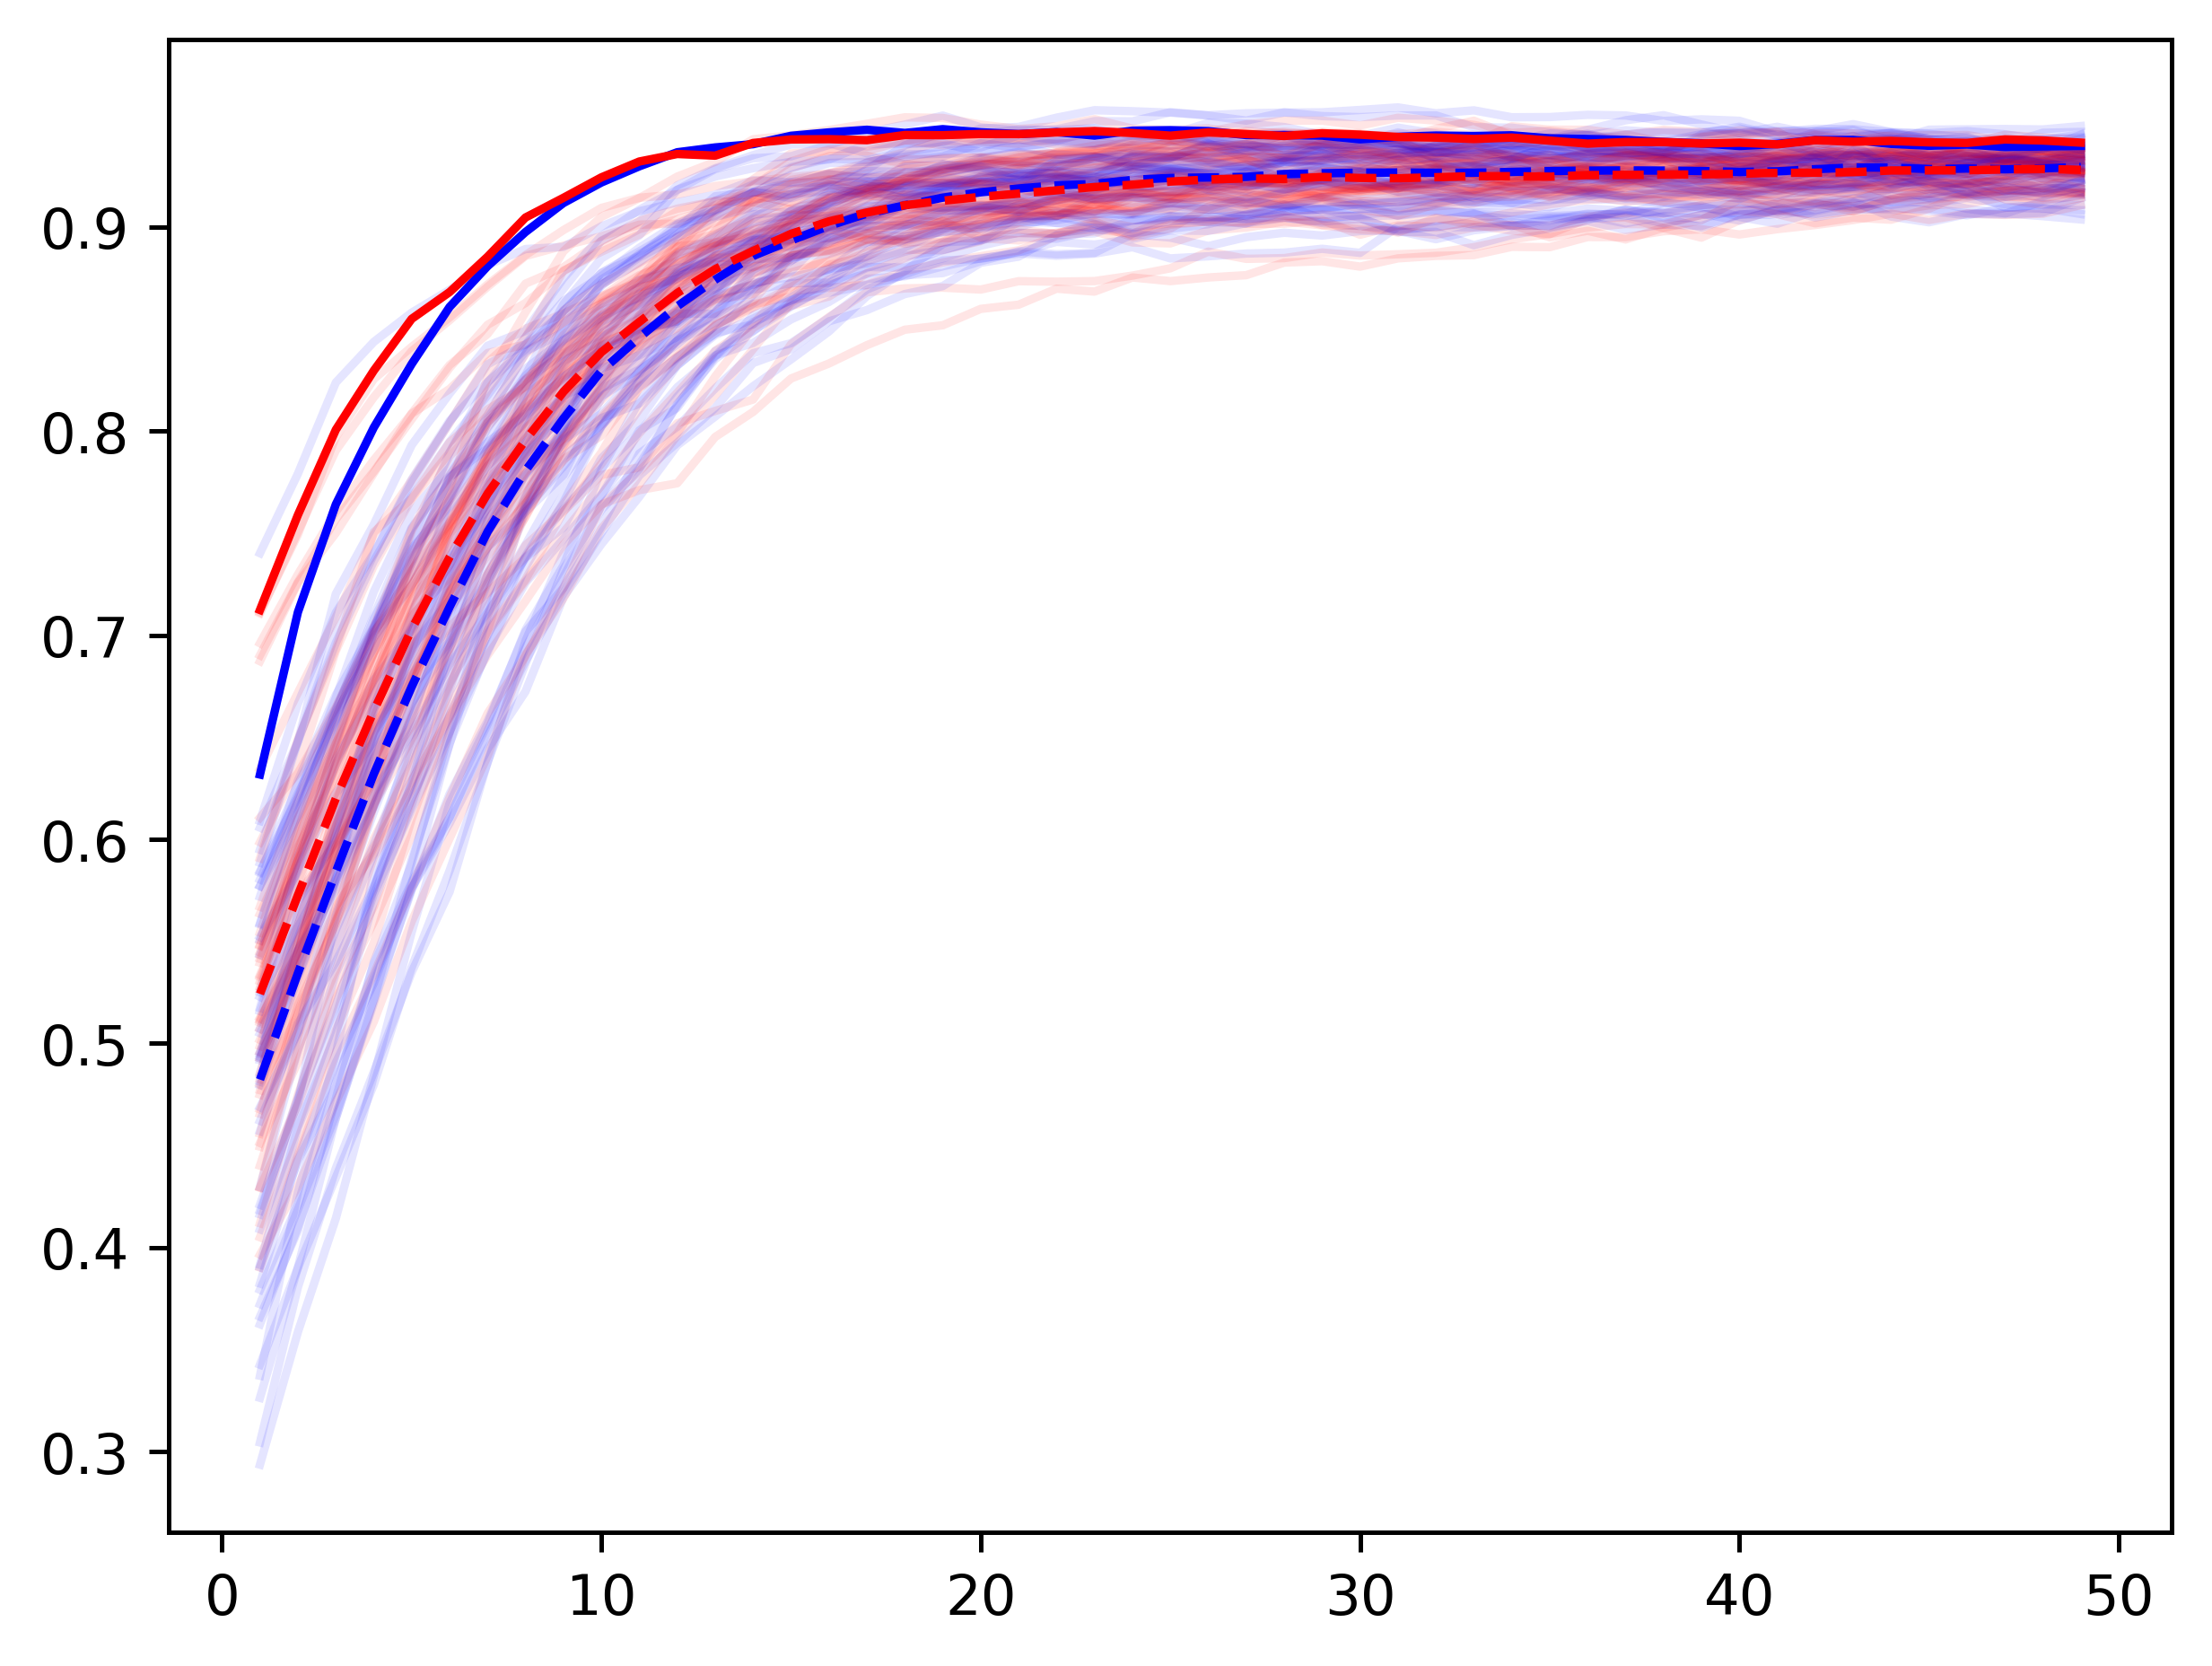

In [128]:
plt.figure(dpi=450)
plot_data_1_ = pd.Series(0, index=range(50))
plot_data_2_ = pd.Series(0, index=range(50))
for idx in range(50):
    test_np_ = pd.read_csv(fr'{result_folder_np}/{idx}/Codons.csv', sep='\t').copy()
    plot_data_1 = test_np_.corrwith(test_np_.iloc[0], axis=1, method='spearman').iloc[1:50]
    plot_data_1_ += plot_data_1
    plt.plot(plot_data_1, alpha=0.1, c='b')
    
    test_str_ = pd.read_csv(fr'{result_folder_str}/{idx}/Codons.csv', sep='\t').copy()
    plot_data_2 = test_str_.corrwith(test_str_.iloc[0], axis=1, method='spearman').iloc[1:50]
    plot_data_2_ += plot_data_2
    plt.plot(plot_data_2, alpha=0.1, c='r')
test_str = pd.read_csv(fr'{result_folder_str}/CodonsMean.csv', sep='\t').copy()
test_np = pd.read_csv(fr'{result_folder_np}/CodonsMean.csv', sep='\t').copy()

plt.plot(plot_data_1_ / 50, c='b', ls='--')
plt.plot(plot_data_2_ / 50, c='r', ls='--')
plt.plot(test_np.corrwith(test_np.iloc[0], axis=1, method='spearman').iloc[1:50], c='b')
plt.plot(test_str.corrwith(test_str.iloc[0], axis=1, method='spearman').iloc[1:50], c='r')

# Selection analysis of short list

In [36]:
short_species_list = ['Mus_musculus', 'Rattus_rattus', 'Felis_catus', 'Homo_sapiens']
coefficients_list = np.arange(0, 0.31, 0.05).round(2)
coefficients_list

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

In [ ]:
for coefficient in coefficients_list[4:]:
    result_folder = fr'..\\local data\Simulation results(short list)\{coefficient}'
    simulation(result_folder=result_folder, codon_usage_table=CU_12, selection_multiplier=coefficient, species_list=short_species_list, samples_number=30)

In [ ]:
# human
human_ms_df = pd.read_csv('..\\local data\human_ms.csv').copy()
human_ms = []
for mut in MUTATIONS:
    mut = mut.replace('_', '>')
    human_ms.append(human_ms_df.loc[human_ms_df.Mut==mut, 'MutSpec'].values[0])
human_ms
human_ms_df
# MUT_SPEC_DATA.loc[len(MUT_SPEC_DATA)] = ['Homo_sapiens'] + human_ms
# MUT_SPEC_DATA.to_csv(r'..\\raw\VertebratePolymorphisms.MutSpecData.OnlyFourFoldDegAllGenes.csv', sep=' ', index=False)

## Human no random

In [ ]:
for coefficient in coefficients_list:
    result_folder = fr'..\\local data\Simulation results(short list) No random\{coefficient}'
    for species in short_species_list[-1:]:
        random.seed(42)
        simulation(result_folder=result_folder, selection_multiplier=coefficient, species_list=[species], samples_number=30)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

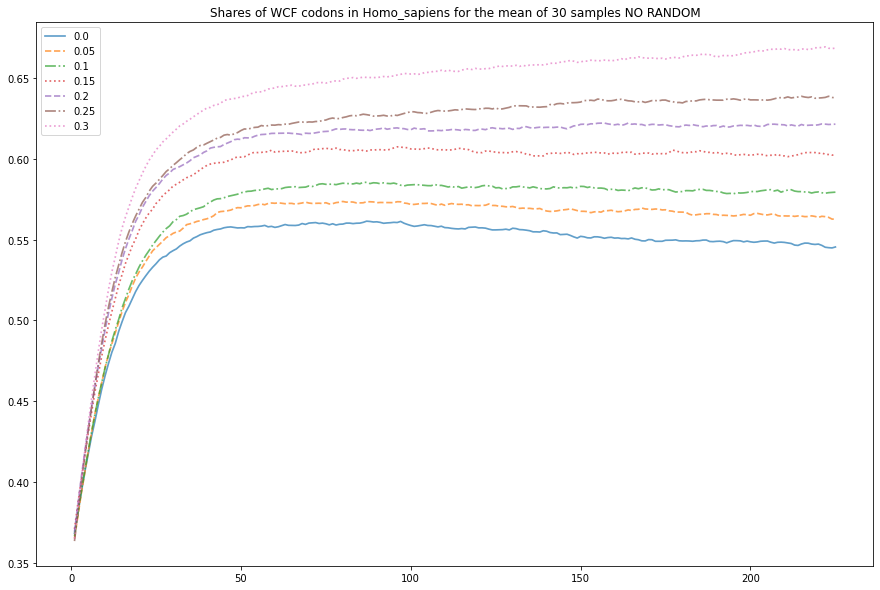

In [ ]:
import matplotlib.pyplot as plt
result_folder = '..\\local data\Simulation results(short list) No random'

lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list[-1:]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(fr'Fraction of WCF codons in {species} for the mean of 30 samples NO RANDOM')
    plt.show()

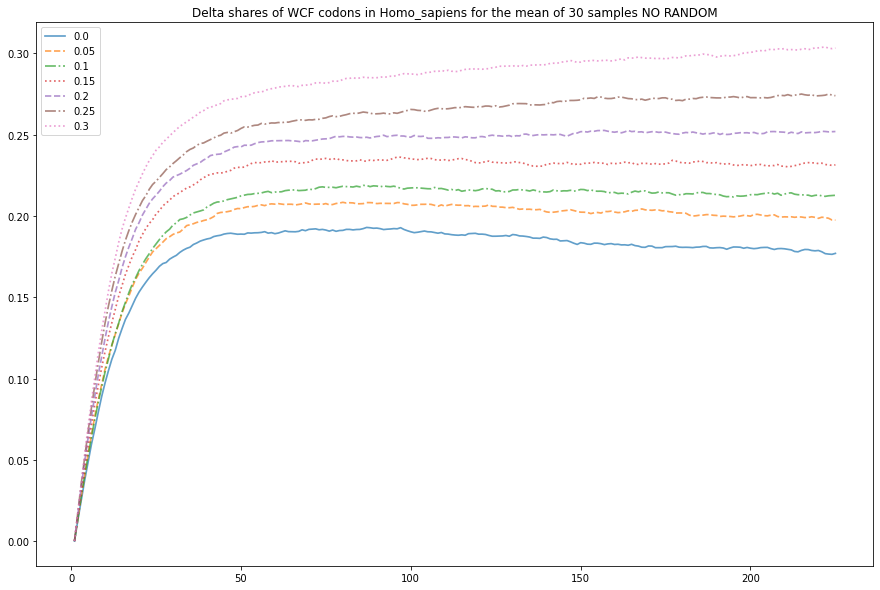

In [ ]:
lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list[-1:]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        wcf_share -= wcf_share[1]
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(fr'Delta fractions of WCF codons in {species} for the mean of 30 samples NO RANDOM')
    plt.show()

## None

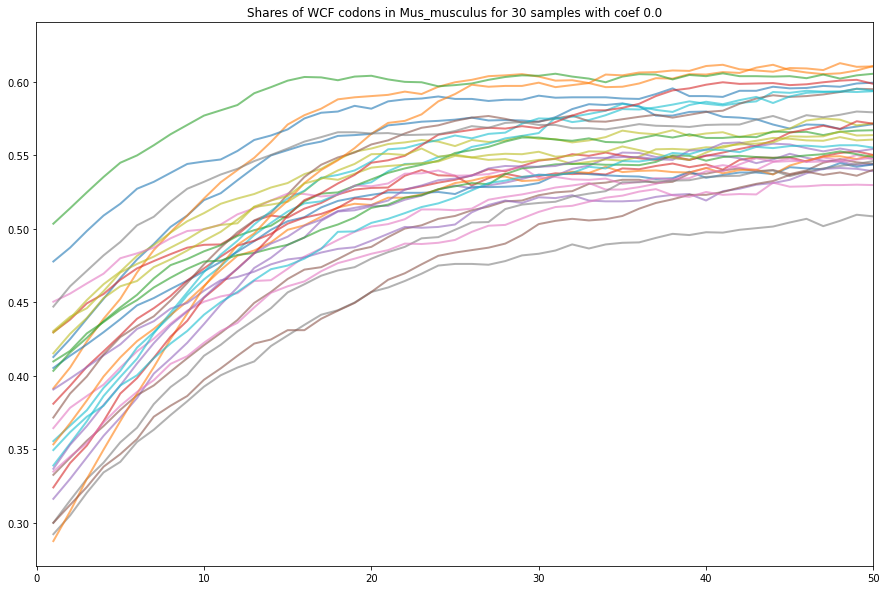

In [ ]:
import matplotlib.pyplot as plt
result_folder = '..\\local data\Simulation results(short list)'
for species in short_species_list[:1]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for sample in range(30):
        for coef in [0.0]:
            wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\{species}\{sample}\Frequencies.csv', mode='Total')
            plt.plot(wcf_share, alpha=0.6, linewidth=2)
            # wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
            # plt.plot(wcf_share, label=coef, alpha=0.5)
    plt.xlim(-0.01, 50)
    plt.title(fr'Fraction of WCF codons in {species} for 30 samples with coef {coef}')
    plt.show()

## not None

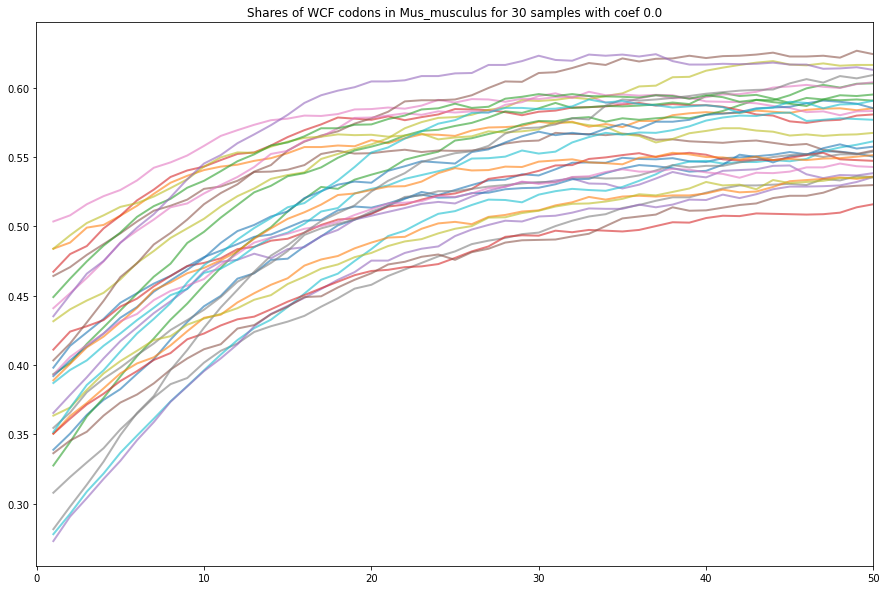

In [ ]:
import matplotlib.pyplot as plt
result_folder = '..\\local data\Simulation results(short list Leu1_2) not None'
for species in short_species_list[:1]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for sample in range(30):
        for coef in [0.0]:
            wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\{species}\{sample}\Frequencies.csv', mode='Total')
            plt.plot(wcf_share, alpha=0.6, linewidth=2)
            # wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
            # plt.plot(wcf_share, label=coef, alpha=0.5)
    plt.xlim(-0.01, 50)
    plt.title(fr'Fraction of WCF codons in {species} for 30 samples with coef {coef}')
    plt.show()

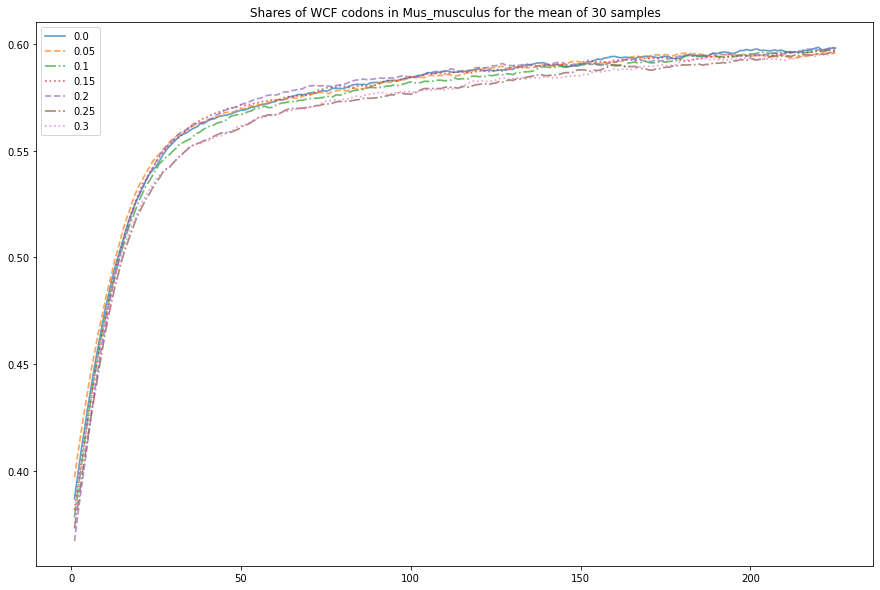

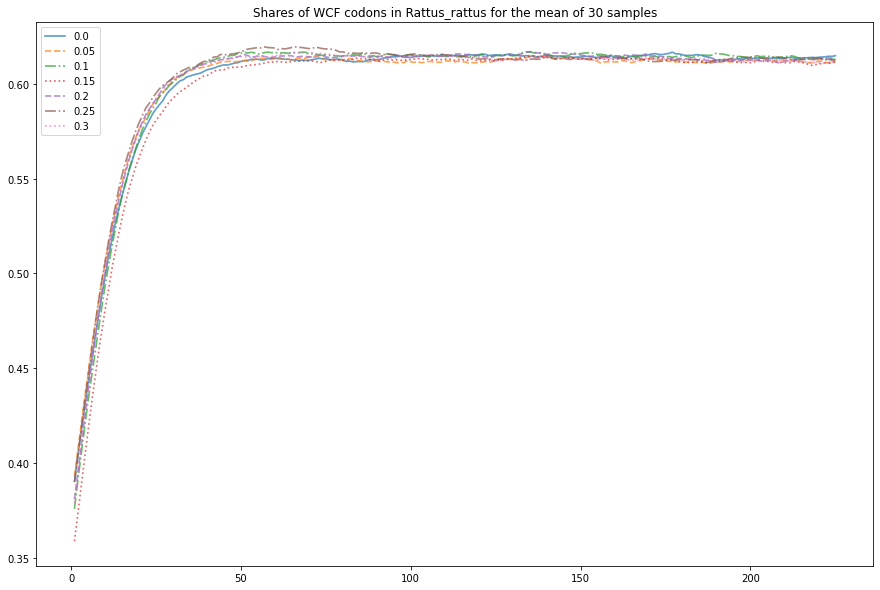

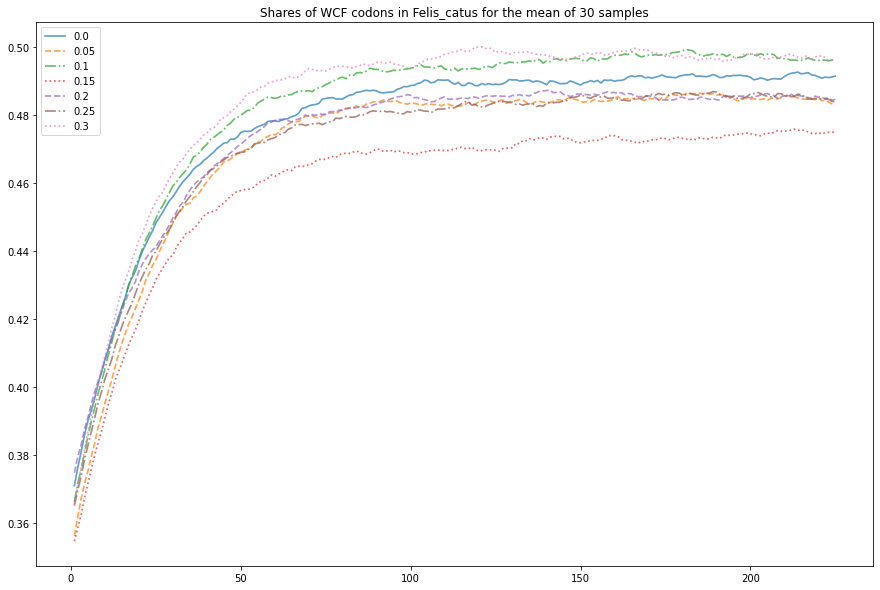

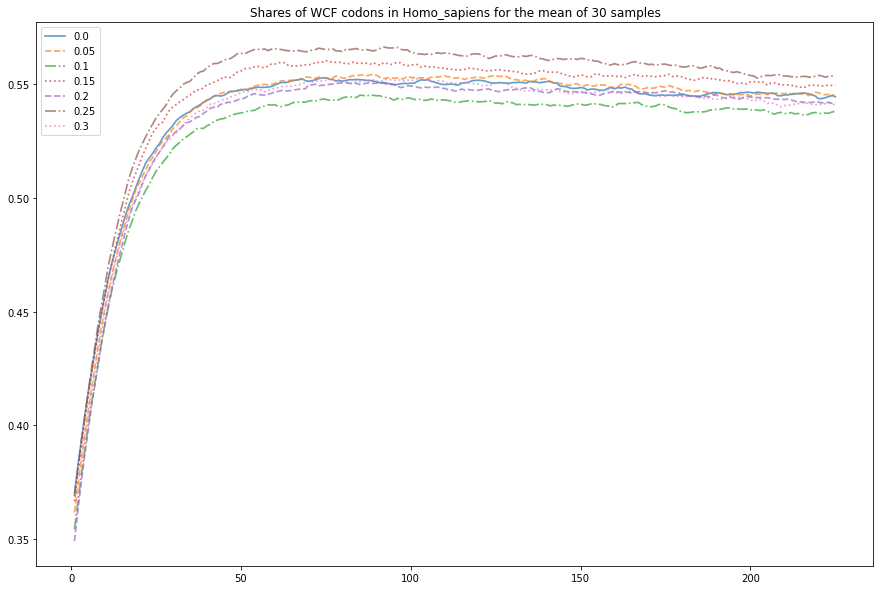

In [ ]:
# WCF_share
lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(fr'Fraction of WCF codons in {species} for the mean of 30 samples')
    plt.show()

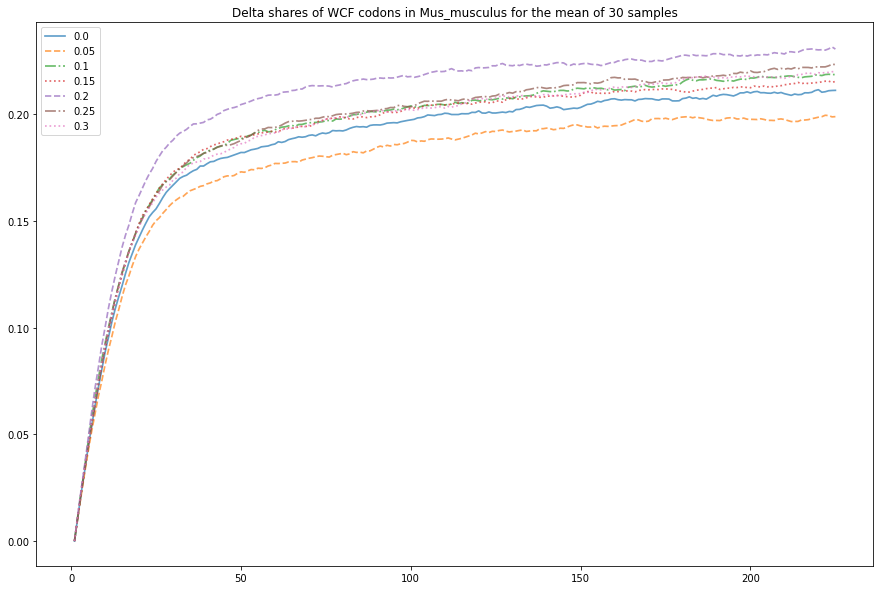

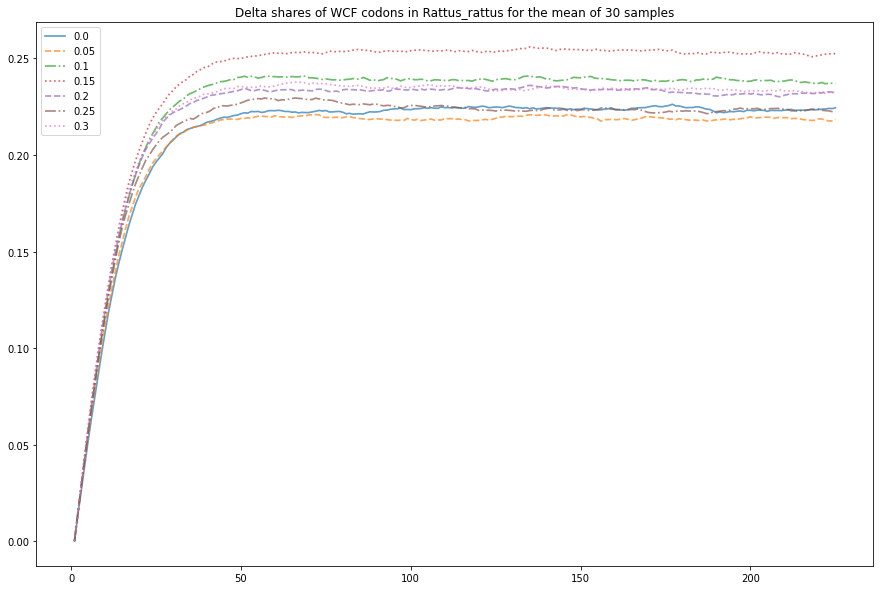

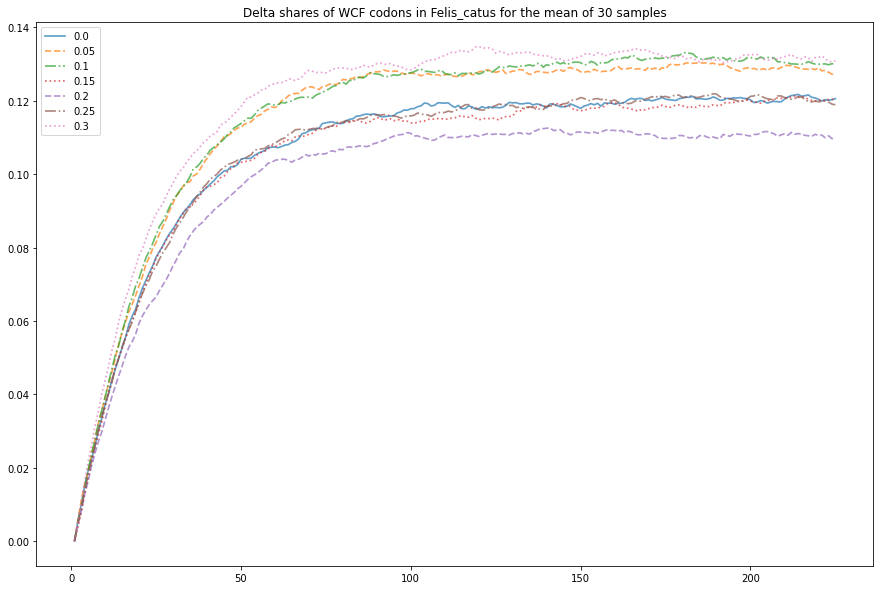

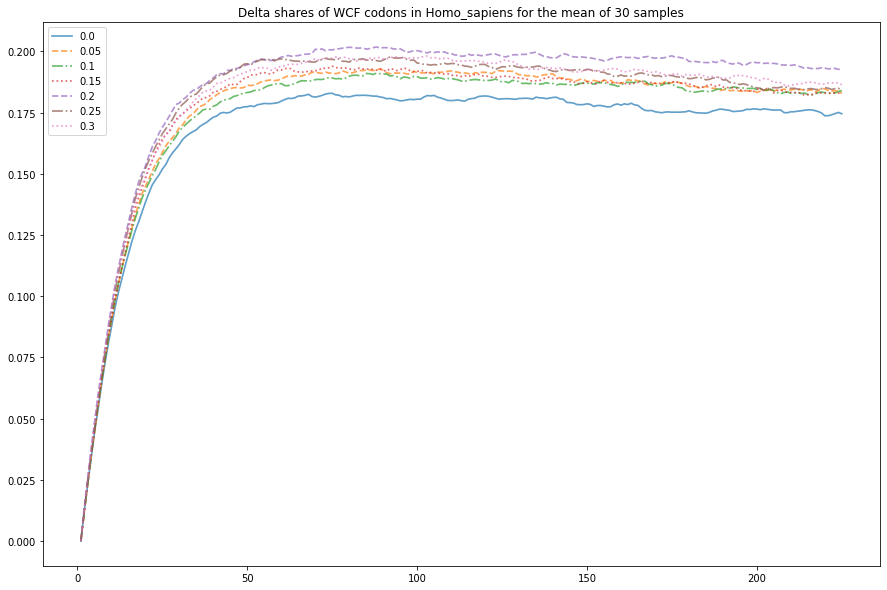

In [ ]:
# delta WCF_share
lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        wcf_share -= wcf_share[1]
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(fr'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(fr'Delta fractions of WCF codons in {species} for the mean of 30 samples')
    plt.show()

## Per genes analysis

In [ ]:
for coefficient in tqdm(coefficients_list):
    for species in short_species_list:
        codons_sum_all_genes = CU_12.loc[CU_12.Species == species, CODONS].iloc[0].sum()
        
        genes_sp = CU_13[CU_13.Species == species].Gene.unique()
        for gene in genes_sp:
            sim_codon_usage = CU_13.loc[(CU_13.Species == species) & (CU_13.Gene==gene), CODONS].iloc[0]
            result_folder = fr'..\\local data\Simulation results(per genes)\{coefficient}\{gene}\{species}'
            simulation(species=species, result_folder=result_folder, codon_usage=sim_codon_usage, selection_multiplier=coefficient, samples_number=30, gene=gene)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# CONTINUE
for coefficient in tqdm(coefficients_list[1:]):
    for species in short_species_list:
        codons_sum_all_genes = CU_12.loc[CU_12.Species == species, CODONS].iloc[0].sum()
        
        genes_sp = CU_13[CU_13.Species == species].Gene.unique()
        for gene in genes_sp:
            sim_codon_usage = CU_13.loc[(CU_13.Species == species) & (CU_13.Gene==gene), CODONS].iloc[0]
            result_folder = fr'..\\local data\Simulation results(per genes)\{coefficient}\{gene}\{species}'
            simulation_continue(species=species, result_folder=result_folder, codon_usage_obs=sim_codon_usage, selection_multiplier=coefficient, samples_number=30, gene=gene)

  0%|          | 0/6 [00:00<?, ?it/s]

# Dictionaries NOT string

In [ ]:
mutations_number = 150*150       # ~22k достаточно для насыщения изменения кодонов
mutations_per_iter = 100
sim_iters_number = mutations_number // mutations_per_iter     # Количество поколений
                    
errouneous_sp_list = []

simulation_species = os.listdir('C:\Work\Lab\Practice\Results_AllGenes_shift')
simulation_species = sorted(list(set(simulation_species)-set(err_list)))
result_folder = '..\\local data\Simulation results(dicts, no sel, no mut_id)'

for species in simulation_species[:1]: # Цикл по списку видов
    probability = 0

    
    MUTATIONS = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']    # Список однонуклеотидных замен
    mutspec = MS[MS.index == species].iloc[0].tolist()  # Вытаскивает мутспек для текущего вида
    # mutspec_stack = []

    # for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
    #     mutspec_stack.append(probability)
    #     probability += float(mutspec[i])


    for sample in tqdm(range(1)): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{species}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе final_simulation_cu текущего вида
        dna = {}
        cu_sp = CU_12[CU_12.Species == species].iloc[0]

        for aa in aa_dict_full:
            aa_codons = aa_dict_full[aa]
            number_aa = cu_sp[aa_codons].sum()
            codon_numbers = constrained_sum_sample_nonneg(len(aa_codons), number_aa)
            dna |= {c:n for c, n in zip(aa_codons, codon_numbers)}

        codon_usage_list = [[cu_sp[c] for c in CODONS]]     # Создаем датафреймы для подсчета final_simulation_cu и
        # iteration_frequencies = []
        observed_frequency = pd.read_csv(r'C:\Work\Lab\Practice\CodonFrequencyAllGenes.csv', sep='\t').copy()
        # iteration_frequencies.append(list(observed_frequency[observed_frequency.Species == species].values[0][1:]))
            # Записывает частоты кодонов из живого генома текущего вида
        codon_mut_choice_time = 0

        dna_keys = list(dna.keys())
        dna_vals = list(dna.values())
        
        for generation in range(sim_iters_number):
            
            errouneous_sp_counter = 0
            if generation % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                codon_usage_list.append([dna[c] for c in CODONS])  # Add a list of codon usage for current gen to final_simulation_cu 
                # frequency_values = []  # Список значений частот кодонов
                # for e in range(64):
                #     frequency_values.append(iteration_cu[generation][e] / sum(dna.values()))   # Расчитывает частоту каждого кодона
                # iteration_frequencies.append(frequency_values)  # Записывает в строку текущего поколения
                # Сохраняет значения
            
            # Мутагенез через список кодонов
            successfull_mutations = 0
            
      

            while successfull_mutations < mutations_per_iter:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_mut_choice_timer = time.time()

                codon = random.choices(dna_keys, weights=dna_vals, k=1)[0] # Choose random codon considering its number in all codon usage
                # mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                mutation_position = 2
                mutation_type = random.choices(MUTATIONS, weights=mutspec, k=1)[0]   # Choose a certain substitution considering its probability
                
                codon_mut_choice_time += time.time()-codon_mut_choice_timer

                if codon[mutation_position] == mutation_type[0]:              # Check if choosen codon and substitution match
                    new_codon = MutableSeq(codon)                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mutation_position] = mutation_type[2]           # Подставляем нуклеотид в кодоне
                    codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    new_codon_aa = seq3(new_codon.translate(table=CODON_TABLE))
                    
                    if new_codon_aa != codon_aa:
                        continue
        
                    # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
                    # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
                    
                    success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                # it's impossible to make a substitution more frequent without it
                    selection_multiplier = 0
                    
                    if success < (0.8+0.8*selection_multiplier):
                        dna[str(codon)] -=1
                        dna[str(new_codon)] += 1 
                        successfull_mutations += 1
        print(codon_mut_choice_time)

        codon_usage_df = pd.DataFrame(data=codon_usage_list, columns=CODONS)
        frequency_df = codon_usage_df / sum(dna.values())
        
        codon_usage_df.to_csv(fr'{result_folder}\{species}\{sample}\Codons.csv', sep='\t', index=False)
        frequency_df.to_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep ='\t', index=False)
        

    # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    samples_number = len(next(os.walk(fr'{result_folder}\{species}'))[1])    # Количество смодулированных образцов

    # Средние частоты
    frequencies_mean_df = pd.DataFrame(0, index=range(sim_iters_number+1), columns=CODONS)


    for sample in range(samples_number):
        freq = pd.read_csv(fr'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        frequencies_mean_df += freq
    frequencies_mean_df /= samples_number
    
    frequencies_mean_df.to_csv(fr'{result_folder}\{species}\FrequenciesMean.csv', sep='\t', index=False)

    # Корреляции
    spearman = []
    pearson = []
    spearman_pval = []
    pearson_pval = []
    observed_cu = frequencies_mean_df.loc[0]
    for i in frequencies_mean_df.index[1:]:
        simulated_cu = frequencies_mean_df.loc[i]
        corrp, p_p = pearsonr(observed_cu, simulated_cu)
        pearson.append(corrp)
        pearson_pval.append(p_p)
        corrs, p_s = spearmanr(observed_cu, simulated_cu)
        spearman.append(corrs)
        spearman_pval.append(p_s)
    
    spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'spearman_pval':spearman_pval, 'pearson_pval':pearson_pval})
    spear_corr.to_csv(fr'{result_folder}\{species}\SpearmanMean.csv', sep='\t', index=False)

print(errouneous_sp_list)

  0%|          | 0/1 [00:00<?, ?it/s]

1.913494348526001
[]


In [ ]:
# Генератор генома на основе final_simulation_cu текущего вида
dna = []


for aa in AAU_12.columns.values[:-1]:
    odds = [0]
    for i in range(len(aa_dict_seq3[aa])):    # Создаем список вероятностей по вырождености аминокислоты
        odds.append(random.random() + odds[-1])
    for k in range(AAU_12[AAU_12.Species == species][aa].values[0]):  # Цикл длиной кол-ву кодонов для аминокислоты
        odd = random.uniform(0, odds[-1])
        for q in range(len(aa_dict_seq3[aa])):    # Для учета вырожденности АА
            if odd < odds[q+1] and odd > odds[q]:
                dna.append(aa_dict_seq3[aa][q])

In [ ]:
species = 'Abbottina_rivularis'
DNA_str = {}
cu_sp = CU_12[CU_12.Species == species].iloc[0]

for aa in aa_dict_full:
    aa_codons = aa_dict_full[aa]
    number_aa = cu_sp[aa_codons].sum()
    codon_numbers = constrained_sum_sample_nonneg(len(aa_codons), number_aa)
    DNA_str |= {c:n for c, n in zip(aa_codons, codon_numbers)}


## Calculation of codon usage

In [ ]:
codon_usage_list = []

# Список однонуклеотидных замен
mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']

for generation in range(sim_iters_number):
    errouneous_sp_counter = 0
    if generation % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
        codon_usage = Counter(dna)      # Расчет final_simulation_cu
        codon_usage_list.append([])
        if len(list(codon_usage)) < 64:                     # Проверка наличия всех 64 кодонов
            for t in ALL_CODONS:                              # без нее возникали ошибки
                if t not in list(codon_usage):              # если кодон исчезает приписываем ему ноль
                    codon_usage[t] = 0
        for codon in ALL_CODONS:     # Записывает final_simulation_cu
            codon_usage_list[generation].append(codon_usage[codon])
        frequency_values = []  # Список значений частот кодонов
        for e in range(64):
            frequency_values.append(codon_usage_list[generation][e] / len(dna))   # Расчитывает частоту каждого кодона
        frequency_list.append(frequency_values)  # Записывает в строку текущего поколения

{0: 'a', 1: 'a', 2: 'a', 3: 'a', 4: 'v', 5: 'v'}

In [ ]:
for generation in range(sim_iters_number):
    errouneous_sp_counter = 0
    if generation % record_frequency == 0: # Регулирует раз в сколько поколений считать частоты кодонов
        codon_usage_list.append([DNA_str[c] for c in CODONS])  # Add a list of codon usage for current gen to final_simulation_cu 
        frequency_values = []  # Список значений частот кодонов
        for e in range(64):
            frequency_values.append(codon_usage_list[generation][e] / len(dna))   # Расчитывает частоту каждого кодона
        frequency_list.append(frequency_values)  # Записывает в строку текущего поколения

Counter({'a': 3, 'p': 3})

## Mutagenesis

In [ ]:
# Мутагенез через список кодонов
successfull_mutations = 0

while successfull_mutations < mutations_per_iter:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
    codon_id = random.randint(0, len(dna)-1)
    codon = MutableSeq(dna[codon_id])   # Выбираем отдельный кодон
    mutation_position = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
    mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
    counter = 0
    while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
        counter += 1
    if codon[mutation_position] == MUTATIONS[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
        
        new_codon = codon                                   # выбранным нуклеотидом из кодона
        codon = Seq(codon)
        new_codon[mutation_position] = MUTATIONS[counter][2]           # Подставляем нуклеотид в кодоне
        codon_aa = seq3(codon.translate(table=CODON_TABLE))
        new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
        
        if new_codon_aa != codon_aa:
            continue

        # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
        # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
        
        success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                    # it's impossible to make a substitution more frequent without it
        selection_multiplier = 0
        
        if success < (0.8+0.8*selection_multiplier):
            dna[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
            successfull_mutations += 1


In [ ]:
# Мутагенез через список кодонов
successfull_mutations = 0

while successfull_mutations < mutations_per_iter:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
    codon = random.choices(list(DNA_str.keys()), weights=list(DNA_str.values()), k=1)[0] # Choose random codon considering its number in all codon usage
    mutation_position = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
    mutation_type = random.choices(MUTATIONS, weights=mutspec, k=1)[0]   # Choose a certain substitution considering its probability
    
    if codon[mutation_position] == mutation_type[0]:              # Check if choosen codon and substitution match
        new_codon = MutableSeq(codon)                                   # выбранным нуклеотидом из кодона
        codon = Seq(codon)
        new_codon[mutation_position] = mutation_type[2]           # Подставляем нуклеотид в кодоне
        codon_aa = seq3(codon.translate(table=CODON_TABLE))
        new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
        
        if new_codon_aa != codon_aa:
            continue

        # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
        # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
        
        success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                    # it's impossible to make a substitution more frequent without it
        selection_multiplier = 0
        
        if success < (0.8+0.8*selection_multiplier):
            dna[str(codon)] -=1
            dna[str(new_codon)] += 1
            successfull_mutations += 1
    else: 
        continue

In [207]:
test = []
for i in range(1000000):
    test.append(random.choices(MUTATIONS, weights=mutspec, k=1)[0])
for i in range(len(mutspec)):
    print(mutspec[i]*1000000, Counter(test)[MUTATIONS[i]])

11369.349052242 11306
28349.523418001398 28283
13838.938422814701 13808
59071.672118970404 58750
7980.8529622716 7862
128591.17014869001 128670
473567.57076442003 473144
51220.9703810743 51694
79542.4227665674 79624
75204.59573014 75554
60217.96316072861 60332
11044.9710740803 10973


In [222]:
a = 'AAA'
b = MutableSeq(a)
a = Seq(a)
b[2] = 'T'
print(a,b)
DNA_str[str(a)]

AAA AAT


14

In [ ]:
MUTATIONS = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']    # Список однонуклеотидных замен
mutspec = MS[MS.index == species].iloc[0].tolist()
random.choices(MUTATIONS, weights=mutspec, k=1)[0]

# Markov chain

In [ ]:
mutations_number = 150*150       # ~22k достаточно для насыщения изменения кодонов
mutations_per_iter = 100
sim_iters_number = mutations_number // mutations_per_iter     # Количество поколений
                    
errouneous_sp_list = []

simulation_species = os.listdir('C:\Work\Lab\Practice\Results_AllGenes_shift')
simulation_species = sorted(list(set(simulation_species)-set(err_list)))
result_folder = '..\\local data\Simulation results(Markov chain)'

for species in simulation_species[:1]: # Цикл по списку видов
    probability = 0

    
    MUTATIONS = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']    # Список однонуклеотидных замен
    mutspec = MS[MS.index == species].iloc[0].tolist()  # Вытаскивает мутспек для текущего вида

A_C    0.005126
A_G    0.024882
A_T    0.009729
C_A    0.019392
C_G     0.00048
C_T    0.099236
G_A    0.621942
G_C    0.020183
G_T    0.019591
T_A    0.024871
T_C    0.150563
T_G    0.004005
Name: 601, dtype: object


In [ ]:
ms_series = MS[MS.index == species].iloc[0][1:].sort_index()
# ms_series.values = np.array([i/sum(ms_series) for i in ms_series])
P = []
for n1 in ['A', 'C', 'G', 'T']:
    matrix_row = []
    for n2 in ['A', 'C', 'G', 'T']:
        if n1 == n2:
            matrix_row.append(0.0)
        else:    
            matrix_row.append(ms_series[fr'{n1}_{n2}'])
    matrix_row = [i/sum(matrix_row) for i in matrix_row]
    P.append(matrix_row)
P = np.array(P)
print(P)


[[0.         0.25839253 0.52932566 0.21228181]
 [0.51345575 0.         0.07540901 0.41113524]
 [0.78362288 0.13162063 0.         0.08475649]
 [0.30193496 0.65727224 0.04079279 0.        ]]


In [62]:
P.sum()

4.0

In [86]:
state = np.array([[100, 100, 100, 100]])
state
print(state)

[[100 100 100 100]]


In [89]:
for i in range(10):
    state = np.dot(state, P)
print(state.sum())

354.0
351.0
349.0
347.0
346.0
344.0
343.0
341.0
338.0
336.0


In [101]:
P = []
for codon1 in CODONS:
    matrix_row = []
    for codon2 in CODONS:
        if codon1 == codon2:
            matrix_row.append(0.0)
        elif codon1[0] != codon2[0] or codon1[1] != codon2[1]:
            matrix_row.append(0.0)
        else:    
            matrix_row.append(ms_series[fr'{codon1[2]}_{codon2[2]}'])
    matrix_row = [i/sum(matrix_row) for i in matrix_row]
    P.append(matrix_row)
P = np.array(P)
print(P[0])

[0.         0.25839253 0.52932566 0.21228181 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [103]:
pd.DataFrame(P, columns=CODONS, index=CODONS)

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
AAA,0.000000,0.258393,0.529326,0.212282,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AAC,0.513456,0.000000,0.075409,0.411135,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AAG,0.783623,0.131621,0.000000,0.084756,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AAT,0.301935,0.657272,0.040793,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
ACA,0.000000,0.000000,0.000000,0.000000,0.0,0.258393,0.529326,0.212282,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGT,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.301935,0.657272,0.040793,0.0,0.000000,0.000000,0.000000,0.000000
TTA,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.258393,0.529326,0.212282
TTC,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.513456,0.000000,0.075409,0.411135
TTG,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.783623,0.131621,0.000000,0.084756


In [125]:
state = [c/sum(codon_usage_list[0]) for c in codon_usage_list[0]]
for i in range(1000):
    state = np.dot(state, P)
print(state)

[0.01893269 0.01326187 0.01144757 0.01044175 0.02936499 0.02056944
 0.01775542 0.01619536 0.00482977 0.00338313 0.0029203  0.00266371
 0.04414409 0.03092182 0.02669153 0.02434632 0.01999524 0.01400616
 0.01209004 0.01102776 0.02057481 0.01441214 0.01244047 0.01134741
 0.00685827 0.00480405 0.00414682 0.00378247 0.04626918 0.03241039
 0.02797647 0.02551835 0.01622802 0.01136732 0.00981221 0.00895007
 0.03052414 0.02138139 0.01845629 0.01683465 0.02154077 0.01508876
 0.01302453 0.01188015 0.01941567 0.01360019 0.0117396  0.01070812
 0.00994932 0.00696925 0.00601582 0.00548724 0.01690419 0.01184096
 0.01022105 0.00932299 0.01352335 0.00947277 0.00817684 0.00745839
 0.03100712 0.0217197  0.01874832 0.01710102]


# Simulation with new MS

In [16]:
species_list = sorted(list(set(species_list_new) & set(species_list_old)))

In [2]:
bad_sim_species = ['Agonostomus_monticola', 'Ailuropoda_melanoleuca',
       'Ambystoma_barbouri', 'Anarhichas_lupus', 'Anguilla_japonica',
       'Anguilla_luzonensis', 'Aotus_nancymaae', 'Apodemus_chejuensis',
       'Apodemus_chevrieri', 'Auxis_rochei', 'Auxis_thazard',
       'Bambusicola_thoracicus', 'Campostoma_anomalum', 'Canis_latrans',
       'Carpiodes_carpio', 'Cebus_albifrons', 'Cercopithecus_albogularis',
       'Crocuta_crocuta', 'Cynomys_ludovicianus', 'Cyprinodon_variegatus',
       'Echinotriton_andersoni', 'Engraulis_encrasicolus',
       'Epinephelus_fuscoguttatus', 'Episoriculus_macrurus',
       'Erinaceus_europaeus', 'Esox_lucius', 'Eulemur_rufus',
       'Felis_catus', 'Garra_orientalis', 'Garrulus_glandarius',
       'Gekko_gecko', 'Gymnocypris_eckloni', 'Gymnodiptychus_dybowskii',
       'Hemibagrus_macropterus', 'Henicorhina_leucosticta',
       'Hippocampus_kuda', 'Hoplobatrachus_tigerinus', 'Hylobates_agilis',
       'Labeo_gonius', 'Leopoldamys_edwardsi', 'Macaca_tonkeana',
       'Martes_melampus', 'Martes_zibellina', 'Megalobrama_terminalis',
       'Meriones_libycus', 'Microcebus_murinus',
       'Micromesistius_poutassou', 'Microphysogobio_alticorpus',
       'Microphysogobio_brevirostris', 'Muntiacus_muntjak',
       'Myotis_ikonnikovi', 'Myotis_macrodactylus', 'Nannoperca_obscura',
       'Nectogale_elegans', 'Neodon_irene', 'Neophocaena_phocaenoides',
       'Nomascus_siki', 'Nycticebus_bengalensis', 'Oncorhynchus_nerka',
       'Ornithorhynchus_anatinus', 'Osmerus_mordax', 'Ovis_orientalis',
       'Panthera_pardus', 'Papio_anubis', 'Papio_cynocephalus',
       'Papio_hamadryas', 'Papio_ursinus', 'Petrocephalus_microphthalmus',
       'Phoxinus_phoxinus', 'Podarcis_muralis', 'Prionailurus_viverrinus',
       'Propithecus_diadema', 'Protobothrops_mucrosquamatus',
       'Pseudogobio_esocinus', 'Pseudopungtungia_nigra',
       'Pungitius_laevis', 'Pungitius_sinensis', 'Rousettus_aegyptiacus',
       'Schizopygopsis_pylzovi', 'Schizopygopsis_thermalis',
       'Schizothorax_prenanti', 'Scomber_australasicus',
       'Scomber_japonicus', 'Sebastiscus_marmoratus',
       'Semnopithecus_entellus', 'Siganus_canaliculatus',
       'Siniperca_chuatsi', 'Stenella_coeruleoalba', 'Sturnira_tildae',
       'Tamiops_swinhoei', 'Tanakia_lanceolata', 'Thunnus_alalunga',
       'Tinca_tinca', 'Tonatia_saurophila', 'Trachurus_trachurus',
       'Tribolodon_brandtii', 'Trimeresurus_albolabris',
       'Triplophysa_bleekeri', 'Tursiops_aduncus',
       'Urocyon_cinereoargenteus', 'Ursus_thibetanus', 'Vireo_olivaceus',
       'Vulpes_lagopus', 'Zacco_platypus']

In [ ]:
gene = 'CytB'
gene_ms = MS_2[(MS_2.index.get_level_values('Species').isin(CU_12.index)) &
                 (MS_2.index.get_level_values('Gene') == gene)]
species_list_new = gene_ms.index.get_level_values('Species').unique()
CU_cytb = CU_13.loc[CU_13.Gene == 'CytB', ['Species']+CODONS]
CU_cytb = CU_cytb.set_index('Species')
gene_cu = CU_cytb
for species in tqdm(bad_sim_species):
    codon_usage = gene_cu.loc[species]
    result_folder_str = fr'..\\local data\Bad sim species (new ms)\{gene}\{species}'
    mutspec = gene_ms.loc[species, 'CytB']
    try:
        simulation_str(result_folder_str, codon_usage, mutspec, samples_number=50, 
                       iteration_number=12000, record_frequency=40, np=False)
    except Exception as e:
        # error_species[species] = e
        print(species, e)

  0%|          | 0/104 [00:00<?, ?it/s]

In [ ]:
gene_ms = MS[MS.index.isin(CU_12.index)]
species_list_old = gene_ms.index.unique()
CU_cytb = CU_13.loc[CU_13.Gene == 'CytB', ['Species']+CODONS]
CU_cytb = CU_cytb.set_index('Species')
gene_cu = CU_cytb
error_species = {}
for species in tqdm(species_list):
    codon_usage = gene_cu.loc[species]
    result_folder_str = fr'..\\local data\Simulation results (old ms)\{gene}\{species}'
    mutspec = gene_ms.loc[species]
    try:
        simulation_str(result_folder_str, codon_usage, mutspec, samples_number=50, 
                       iteration_number=12000, record_frequency=40, np=True)
    except Exception as e:
        error_species[species] = e

  0%|          | 0/355 [00:00<?, ?it/s]

In [18]:
error_species

{'Anguilla_japonica': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Anguilla_rostrata': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Crocuta_crocuta': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Hypomesus_olidus': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Leptonychotes_weddellii': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Lophura_nycthemera': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Marmota_himalayana': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Micromys_minutus': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Microphysogobio_alticorpus': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Mus_cervicolor': IndexError('index 900000 is out of bounds for axis 0 with size 900000'),
 'Myotis_macrodactylus': IndexError('ind

## Attemp to multithread

In [ ]:
def run_simulation(args):
    species, codon_usage_species, mutspec_species = args
    # error_species = {}
    try:    
        result_folder = fr'..\\local data\Simulation results (new ms)\{gene}\{species}'
        simulation_str(result_folder, codon_usage_species, mutspec_species, samples_number=5, iteration_number=30000, np=True)
    except Exception as e:
        # error_species[species] = e
        print(species, e)

In [ ]:
if __name__ == '__main__':
    # gene = 'CytB'
    # gene_ms = MS_new[(MS_new.index.get_level_values('Species').isin(CU_12.index)) &
    #                  (MS_new.index.get_level_values('Gene') == gene)]
    species_list = gene_ms.index.get_level_values('Species').unique()
    species_data = [(species,
                     CU_12.loc[species],
                     MS_2.loc[species, gene])
                     for species in species_list]
    
    with multiprocessing.Pool(processes=4) as pool:
        # Use imap_unordered for better performance and tqdm for progress bar
        for _ in tqdm(pool.imap_unordered(run_simulation, species_data), total=len(species_list)):
            pass  # The loop body is empty because processing is done in run_simulation

  0%|          | 0/477 [00:00<?, ?it/s]